In [1]:
import jax
from jax import random, Array
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import *

from gp import k, mk_cov, cholesky_inv, create_toy_sparse_dataset, PlotContext

key = random.PRNGKey(42)  # Create a random key                        

# Variational Gaussian Processes (VGPs)

In this notebook, we explore a Variational GP (VGP) which is a kind of sparse GP aimed at solving the scaling problems of GPs by approximating the GP posterior with **variational inference**. As before, we'll reintroduce a toy dataset for illustrative purposes.

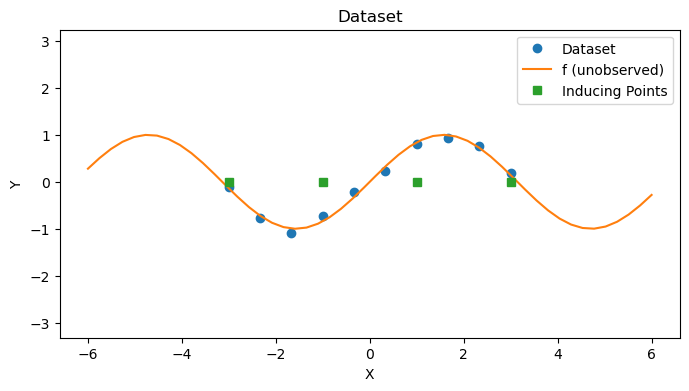

In [2]:
# Create dataset
f = lambda x: jnp.sin(x)
xs, zs, ys, Sigma = create_toy_sparse_dataset(f, key)
N, M = len(xs), len(zs)

with PlotContext(title="Dataset", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

## VGP Model

In **variational inference**, we *approximate* a complex probability distribution $p$ with a simpler distribution $q$ from a variational family that has more tractable properties compared to $p$. In VGP [1], we choose the distribution $q(f, u)$ to be a approximate the posterior $p(f, u | y)$ where $u$ are the evaluations of a function choosen at $M$ inducing points $\{ z_i \}_{1 \leq i \leq M}$. That is, we will solve

$$
\operatorname{min} KL(q(f, u) || p(f, u | y))
$$

to obtain a $q(f, u) \approx p(f, u | y)$. Posterior predictive inference can then be performed by using the posterior predictive $q(f_* | y)$.

### VGP Approximation

To construct the approximation $q(f, u)$, we choose

$$
q(f | u) = p(f | u)
$$

and solve for $q(u)$ (See Appendix for derivation). This differs from the approach taken in SoR, which assumes that $q(u) \sim \mathcal{N}(0, K_{uu})$ and approximates $p(f | u) \approx q_{SoR}(f | u)$. Titsias shows that
\begin{align*}
q(u) & = \mathcal{N}(u \,|\, K_{zz}C^{-1}K_{zx}\Sigma^{-1} y, K_{zz}C^{-1}K_{zz})
\end{align*}
where $C = K_{zz} + K_{zx}\Sigma^{-1} K_{xz}$.

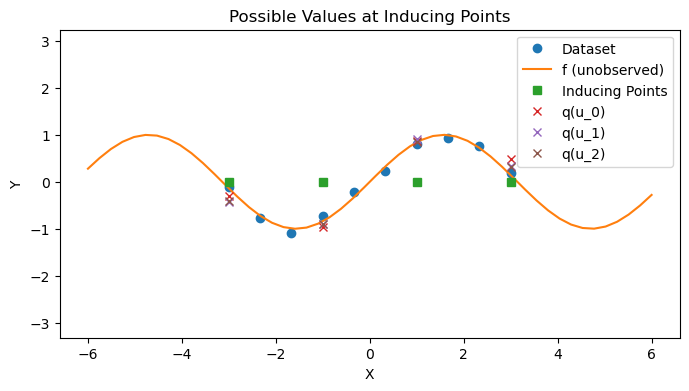

In [3]:
# Compute kernel
K_zz = mk_cov(k, zs, zs)
K_zx = mk_cov(k, zs, xs)
K_xz = K_zx.transpose()

# Compute mean and covariance
Sigma_inv = cholesky_inv(Sigma)
C = K_zz + K_zx @ Sigma_inv @ K_xz
C_inv = cholesky_inv(C)
m = (K_zz @ C_inv @ K_zx @ Sigma_inv @ ys).reshape(-1)
cov = K_zz @ C_inv @ K_zz

# Sample q(u)
us = random.multivariate_normal(key, mean=m, cov=cov, shape=(3,)).transpose()

with PlotContext(title="Possible Values at Inducing Points", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")

    # Plot q(u)
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")
    for i in range(3):
        plt.plot(zs, us[:, i], marker="x", linestyle="None", label=f"q(u_{i})")

## Fitting a VGP

The posterior predictive of a VGP (see Titsias [2], eq 6 and also the Appendix) is
\begin{align*}
q(f_* | y) & = \mathcal{N}(K_{*z}C^{-1}K_{zx}\Sigma^{-1}y, K_{* *} - K_{*z}(K_{zz}^{-1} - C^{-1})K_{z*}) \,.
\end{align*}
As a reminder, $C = K_{zz} + K_{zx}\Sigma^{-1} K_{xz}$.

In [4]:
def fit_vgp(k: Callable, Sigma: Array, xs: Array, ys: Array, zs: Array):
    # Compute covariances
    K_zz = mk_cov(k, zs, zs)
    K_xz = mk_cov(k, xs, zs)
    K_zx = K_xz.transpose()
    K_zz_inv = cholesky_inv(K_zz)
    
    # Perform approximations
    Sigma_inv = cholesky_inv(Sigma)
    C = K_zz + K_zx @ Sigma_inv @ K_xz
    C_inv = cholesky_inv(C)
    
    alpha = C_inv @ K_zx @ Sigma_inv @ ys
    cov = K_zz_inv - C_inv
    
    return alpha, cov, K_zz, K_zz_inv

In [5]:
def vgp_post_pred_mean(k: Callable, zs: Array, alpha: Array, x_star: Array) -> Array:
    """Posterior predictive mean.
    """
    K_star_z = mk_cov(k, x_star, zs).reshape(-1)
    return K_star_z @ alpha


def vgp_post_pred_cov(k: Callable, zs: Array, cov: Array, x_star: Array) -> Array:
    """Posterior predictive covariance.
    """
    K_star_star = mk_cov(k, x_star, x_star)
    K_star_z = mk_cov(k, x_star, zs)
    return K_star_star - K_star_z @ cov @ K_star_z.transpose()

### Visualizing the Posterior Predictive 1: No Inducing Points

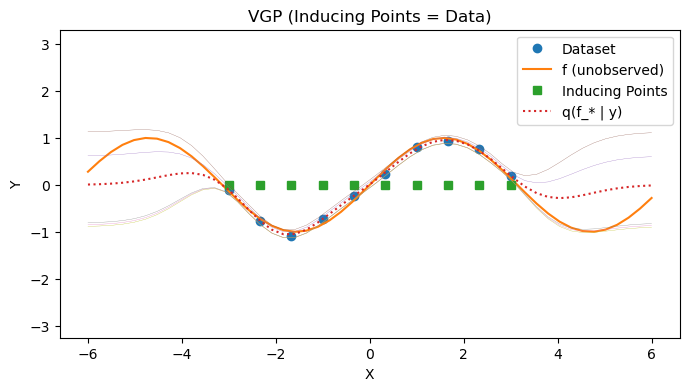

In [6]:
# Fit
zs_all_xs = xs
alpha_all_xs, cov_all_xs, K_zz_all_xs, K_zz_inv_all_xs = fit_vgp(k, Sigma, xs, ys, zs_all_xs)

# Predict
test_xs = jnp.linspace(-6, 6).reshape(-1, 1)
post_ys = [vgp_post_pred_mean(k, zs_all_xs, alpha_all_xs, x) for x in test_xs]
post_mean = jax.vmap(lambda x_star: vgp_post_pred_mean(k, zs_all_xs, alpha_all_xs, x_star))(test_xs)
post_cov = jax.vmap(lambda x_star: vgp_post_pred_cov(k, zs_all_xs, cov_all_xs, x_star), out_axes=0)(test_xs)
post_cov_ys = [random.normal(key, shape=(5,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i] for i in range(len(test_xs))]

with PlotContext(title="VGP (Inducing Points = Data)", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs[:,0], ys, marker='o', linestyle='none', label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")
    plt.plot(zs_all_xs, jnp.zeros_like(zs_all_xs), marker="s", linestyle="None", label="Inducing Points")

    # Plot p(f(*) | y)
    plt.plot(test_xs, post_ys, label="q(f_* | y)", linestyle="dotted")
    plt.plot(test_xs, post_cov_ys, linewidth=0.2)

### Visualizing the Posterior Predictive 2: Subset

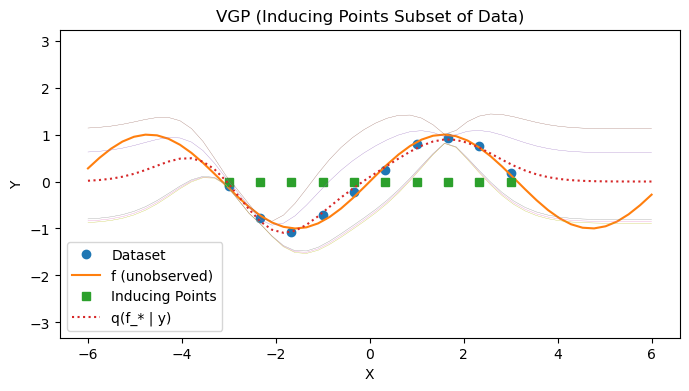

In [7]:
# Fit
zs_p = jnp.array([xs[0], xs[1], xs[-3]])
alpha_p, cov_p, K_zz_p, K_zz_inv_p = fit_vgp(k, Sigma, xs, ys, zs_p)

# Predict
test_xs = jnp.linspace(-6, 6).reshape(-1, 1)
post_ys = [vgp_post_pred_mean(k, zs_p, alpha_p, x) for x in test_xs]
post_mean = jax.vmap(lambda x_star: vgp_post_pred_mean(k, zs_p, alpha_p, x_star))(test_xs)
post_cov = jax.vmap(lambda x_star: vgp_post_pred_cov(k, zs_p, cov_p, x_star), out_axes=0)(test_xs)
post_cov_ys = [random.normal(key, shape=(5,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i] for i in range(len(test_xs))]

# Plot
with PlotContext(title="VGP (Inducing Points Subset of Data)", xlabel="X", ylabel="Y") as ax:
    # Plot dataset and inducing points
    plt.plot(xs[:,0], ys, marker='o', linestyle='none', label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")
    plt.plot(zs_all_xs, jnp.zeros_like(zs_all_xs), marker="s", linestyle="None", label="Inducing Points")

    # Plot p(f(*) | y)
    plt.plot(test_xs, post_ys, label="q(f_* | y)", linestyle="dotted")
    plt.plot(test_xs, post_cov_ys, linewidth=0.2)

## Summary

1. We have seen how variational inference can be applied to make GP inference tractable.
2. We have illustrated VGP on a toy dataset.

## References

1. [Variational Model Selection for Sparse Gaussian Process Regression](https://mtitsias.github.io/files/sparseGPv2.pdf)
2. [Variational Learning of Inducing Variables in Sparse Gaussian
Processes](https://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf)

## Appendix

### Appendix: VGP Derivation

We want to solve

$$
\operatorname{min} KL(q(f, u) || p(f, u | y))
$$

where

$$
q(f, u) = p(f | u) q(u) \,.
$$

Titsias shows that
\begin{align*}
q(u) & = \mathcal{N}(u \,|\, K_{zz}C^{-1}K_{zx}\Sigma^{-1} y, K_{zz}C^{-1}K_{zz})
\end{align*}
where $C = K_{zz} + K_{zx}\Sigma^{-1} K_{xz}$.

#### Generative Process

As a reminder, the generative process for a GP with inducing points is
\begin{align*}
    u(z) & \sim \mathcal{N}(0, K_{zz}) \\
    f(x) \,|\, u(z) & \sim \mathcal{N}(K_{xz}K_{zz}^{-1}u(z), K_{xx} - Q_{xx}) \\
    \epsilon & \sim \mathcal{N}(0, \Sigma) \\
    y & = f(x) + \epsilon
\end{align*}
where $\Sigma = \beta^2I$ and $Q_{xx} = K_{xz}K_{zz}^{-1}K_{zx}$. We will abbreviate $u(z) = u$ and $f(x) = f$.

Note that

$$
p(f, u) = \mathcal{N} \left(f, u | 0, 
\begin{pmatrix}
K_{xx} & K_{xz} \\
K_{zx} & K_{zz}
\end{pmatrix}
\right) \,.
$$

#### VGP Derivation: ELBO

Titsias shows in Appendix A [1] that
\begin{align}
    \text{ELBO}(q(f, u)) & = \int q(f, u) \log \frac{p(y, f, u)}{q(f, u)} df du \tag{defn ELBO} \\
    & = \int p(f \,|\, u) q(u) \log \frac{p(y \,|\, f) p(f \,|\, u) p(u)}{p(f \,|\, u) q(u)} df du \tag{defn $p$ and $q$} \\
    & = \int p(f \,|\, u) q(u) \log \frac{p(y \,|\, f) p(u)}{q(u)} df du \tag{cancel} \\
    & = \int \left[ \int \left( \log p(y \,|\, f) + \log \frac{p(u)}{q(u)} \right) p(f \,|\, u) df \right] q(u) du \tag{rearrange} \\
    & = \int \left[ \int \log p(y \,|\, f) \cdot p(f \,|\, u) df + \log \frac{p(u)}{q(u)} \right] q(u) du \tag{linearity and integrate} \,.
\end{align}

#### VGP Derivation: ELBO Inner Integral

We solve for the inner integral. Titsias further shows in Appendix A [1] that
\begin{align*}
    & \phantom{=} \int \log p(y \,|\, f) \cdot p(f \,|\, u) df \notag \\
    & = \int \log \left[ (2\pi)^{-N/2} \beta^{-N} \exp \left( -\frac{1}{2} (y - f)^T\Sigma^{-1}(y - f) \right) \right] p(f \,|\, u) df \tag{Gaussian pdf} \\
    & = \int \left[ -\frac{N}{2} \log 2\pi\beta^2 + \left( -\frac{1}{2} (y - f)^T\Sigma^{-1}(y - f) \right) \right] p(f \,|\, u) df \tag{log} \\
    & = \int \left[ -\frac{N}{2} \log 2\pi\beta^2 - \frac{1}{2\beta^2}Tr(yy^T - 2y f^T + ff^T) \right] p(f \,|\, u) df \tag{trace rearrange} \\
    & = -\frac{N}{2} \log 2\pi\beta^2 - \frac{1}{2\beta^2} \int Tr(yy^T - 2y f^T + ff^T) p(f \,|\, u) df \tag{linearity and integrate} \\
    & = -\frac{N}{2} \log 2\pi\beta^2 - \frac{1}{2\beta^2} \int (Tr(yy^T) - Tr(2y f^T) + Tr(ff^T)) p(f \,|\, u) df \tag{linearity trace} \\
    & = -\frac{N}{2} \log 2\pi\beta^2 - \frac{1}{2\beta^2} \left((Tr(yy^T) + \int - Tr(2y f^T) + Tr(ff^T)) p(f \,|\, u) df \right) \tag{indep} \\
    & = -\frac{N}{2} \log 2\pi\beta^2 - \frac{1}{2\beta^2} \left((Tr(yy^T) - Tr(2y \alpha^T) +  \int Tr(ff^T)) p(f \,|\, u) df \right) \tag{mean} \\
    & = -\frac{N}{2} \log 2\pi\beta^2 - \frac{1}{2\beta^2} \left((Tr(yy^T) - Tr(2y \alpha^T) + Tr(\alpha\alpha^T + B) \right) \tag{second moment} \\
    & = -\frac{N}{2}\log 2\pi\beta^2 - \frac{1}{2\beta^2}Tr(yy^T - 2y\alpha^T + \alpha\alpha^T) - \frac{1}{2\beta^2}Tr(B) \tag{linearity trace} \\
    & = -\frac{N}{2}\log 2\pi\beta^2 - \frac{1}{2\beta^2}(y - \alpha)^T \Sigma^{-1}(y - \alpha)- \frac{1}{2\beta^2}Tr(B) \tag{algebra} \\
    & = \log \mathcal{N}(y \,|\, \alpha, \Sigma) - \frac{1}{2\beta^2}Tr(B) \tag{Gaussian pdf}
\end{align*}
where $\alpha = K_{xz}K_{zz}^{-1}u$ is mean of $p(f \,|\, u)$ and $B = K_{xx} - Q_{xx}$ is covariance of $p(f \,|\, u)$.

#### VGP Derivation: Continue ELBO Simplification

We can now continue to simplify the ELBO.
\begin{align*}
    \text{ELBO}(q(f, u)) & = \int \left[ \int \log p(y \,|\, f) \cdot p(f \,|\, u) df + \log \frac{p(u)}{q(u)} \right] q(u) du \tag{defn} \\
    & = \int \left[ \log \mathcal{N}(y \,|\, \alpha, \Sigma) - \frac{1}{2\beta^2}Tr(B) + \log \frac{p(u)}{q(u)} \right] q(u) du \tag{previous} \\
    & = \int \left[ \log \mathcal{N}(y \,|\, \alpha, \Sigma) + \log \frac{p(u)}{q(u)} \right] q(u) du - \frac{1}{2\beta^2}Tr(B) \tag{linearity and integrate} \\
    & = \int \left[ \log \frac{\mathcal{N}(y \,|\, \alpha, \Sigma) p(u)}{q(u)} \right] q(u) du - \frac{1}{2\beta^2}Tr(B) \tag{log, Eq *} \\
    & \leq \log \int \left[\frac{\mathcal{N}(y \,|\, \alpha, \Sigma) p(u)}{q(u)} \right] q(u) du - \frac{1}{2\beta^2}Tr(B) \tag{Jensen's} \\
    & \leq \log \int \mathcal{N}(y \,|\, \alpha, \Sigma) p(u) du - \frac{1}{2\beta^2}Tr(B) \tag{simpl} \\
    & = \log \int \mathcal{N}\left(
    \begin{pmatrix}
        y \\
        u
    \end{pmatrix} \,|\,
    \begin{pmatrix}
        0 \\
        K_{xz}K_{zz}^{-1}u
    \end{pmatrix}, \begin{pmatrix}
        K_{zz} & K_{zx} \\
        K_{xz} & \Sigma
    \end{pmatrix}\right) du - \frac{1}{2\beta^2}Tr(B) \tag{joint/cond} \\
    & = \log \mathcal{N}(y \,|\, 0, \Sigma + K_{xz}K_{zz}^{-1}K_{zx}) - \frac{1}{2\beta^2}Tr(B) \tag{marg} 
\end{align*}

#### VGP Derivation: Solving ELBO for q(u) step 1

We now need to find the optimal $q(u)$. We can see that $q(u) \propto \mathcal{N}(y \,|\, \alpha, \Sigma) p(u)$ by differentiating the ELBO at Eq * w.r.t. $q(u)$ and setting it to $0$.
\begin{align*}
    q(u) & \propto \mathcal{N}(y \,|\, \alpha, \Sigma) p(u) \tag{*} \\
    & = c_1 \exp\left[ -\frac{1}{2}(y - \alpha)^T\Sigma^{-1} (y - \alpha) \right] c_2 \exp\left[ -\frac{1}{2}u^T K_{zz}^{-1}u \right] \tag{pdf} \\
    & = c_1 c_2 \exp\left[ -\frac{1}{2}(y - \alpha)^T\Sigma^{-1} (y - \alpha) -\frac{1}{2}u^T K_{zz}^{-1}u \right] \tag{simpl} \\
    & = c_1 c_2 \exp\left[ -\frac{1}{2}\left( y^T\Sigma^{-1} y - 2y^T \Sigma^{-1} \alpha + \alpha^T \Sigma^{-1} \alpha + u^T K_{zz}^{-1}u \right) \right] \tag{simpl} \\
    & = c_1 c_2 c_3 \exp\left[ -\frac{1}{2}\left(-2y^T \Sigma^{-1} \alpha + \alpha^T \Sigma^{-1} \alpha + u^T K_{zz}^{-1}u \right) \right] \tag{simpl} \\
    & = c \exp\left[ -\frac{1}{2}\left(-2y^T \Sigma^{-1} (K_{xz}K_{zz}^{-1}u) + u^T K_{zz}^{-1} K_{zx} \Sigma^{-1} K_{xz}K_{zz}^{-1}u + u^T K_{zz}^{-1}u \right) \right] \tag{defn $\alpha$} \\
    & = c \exp\left[ -\frac{1}{2}\left(u^T (K_{zz}^{-1} + K_{zz}^{-1} K_{zx} \Sigma^{-1} K_{xz}K_{zz}^{-1})u - 2y^T \Sigma^{-1} K_{xz}K_{zz}^{-1}u \right) \right] \tag{rearrange}
\end{align*}

####  VGP Derivation: Solving ELBO for q(u) step 2

We can complete the square using
\begin{align*}
    x^TMx - 2b^Tx = (x - M^{-1}b)^TM(x - M^{-1}b) - b^Tb
\end{align*}
to obtain
\begin{align*}
    q(u) = \mathcal{N}(u \,|\, D^{-1}K_{zz}^{-1}K_{zx}\Sigma^{-1} y, D^{-1})
\end{align*}
where
\begin{align*}
D = K_{zz}^{-1}K_{zx}\Sigma^{-1} K_{xz}K_{zz}^{-1} + K_{zz}^{-1} \,.
\end{align*}

Titsias further simplies this to
\begin{align*}
    q(u) & = \mathcal{N}(u \,|\, K_{zz}C^{-1}K_{zx}\Sigma^{-1} y, K_{zz}C^{-1}K_{zz})
\end{align*}
where $C = K_{zz} + K_{zx}\Sigma^{-1} K_{xz}$ as required.

### Appendix: Posterior Predictive

#### Variational Family

Note that

$$
q(f, u) = \mathcal{N} \left(
\begin{pmatrix}
f \\
u \\
\end{pmatrix} |
\begin{pmatrix}
K_{xz}K_{zz}^{-1}m \\
m \\
\end{pmatrix},
\begin{pmatrix}
K_{xx} - K_{xz}K_{zz}^{-1}(K_{zz} - A)K_{zz}^{-1}K_{zx} & K_{xz}K_{zz}^{-1}A \\
AK_{zz}^{-1}K_{zx} & A \\
\end{pmatrix}
\right)
$$

where
1. $m = K_{zz} C^{-1} K_{zx}\Sigma^{-1}y$,
2. $A = K_{zz} C^{-1} K_{zz}$, and
3. $C = (K_{zz} + K_{zx}\Sigma^{-1}K_{xz})$.

#### Computing Posterior Predictive

\begin{align*}
    q(f(*) \,|\, y) & = \int p(f(*) \,|\, f, u) q(f, u) df du \tag{marg} \\
    & = \int p(f(*) \,|\, f, u) p(f \,|\, u) q(u) df du \tag{factor} \\
    & = \int p(f(*), f \,|\, u) q(u) df du \tag{factor} \\
    & = \int q(*, u) du \tag{defn} \\
    & = \mathcal{N}(K_{*z}K_{zz}^{-1}m, K_{* *} - K_{*z}K_{zz}^{-1}(K_{zz} - A)K_{zz}^{-1}K_{z*}) \tag{marg} \\
    & = \mathcal{N}(K_{*z}K_{zz}^{-1}K_{zz} C^{-1} K_{zx}\Sigma^{-1}y, K_{* *} - K_{*z}K_{zz}^{-1}(K_{zz} - A)K_{zz}^{-1}K_{z*}) \tag{subst m} \\
    & = \mathcal{N}(K_{*z} C^{-1} K_{zx}\Sigma^{-1}y, K_{* *} - K_{*z}K_{zz}^{-1}(K_{zz} - A)K_{zz}^{-1}K_{z*}) \tag{simplify} \\
    & = \mathcal{N}(K_{*z} C^{-1} K_{zx}\Sigma^{-1}y, K_{* *} - K_{*z}K_{zz}^{-1}K_{z*} + K_{*z}K_{zz}^{-1}AK_{zz}^{-1}K_{z*}) \tag{distribute} \\
    & = \mathcal{N}(K_{*z} C^{-1} K_{zx}\Sigma^{-1}y, K_{* *} - K_{*z}K_{zz}^{-1}K_{z*} + K_{*z}C^{-1}K_{z*}) \tag{subst A} \\
    & = \mathcal{N}(K_{*z} C^{-1} K_{zx}\Sigma^{-1}y, K_{* *} - K_{*z}(K_{zz}^{-1} - C^{-1})K_{z*}) \tag{rearrange} \\
\end{align*}